In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Paths for data.
Ravdess = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "cremad/AudioWAV/"
Tess = "toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "surrey-audiovisual-expressed-emotion-savee/ALL/"

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio")

Skipping, found downloaded files in "./ravdess-emotional-speech-audio" (use force=True to force download)


In [4]:
od.download("https://www.kaggle.com/datasets/ejlok1/cremad")
od.download("https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee")
od.download("https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess")

Skipping, found downloaded files in "./cremad" (use force=True to force download)
Skipping, found downloaded files in "./surrey-audiovisual-expressed-emotion-savee" (use force=True to force download)
Skipping, found downloaded files in "./toronto-emotional-speech-set-tess" (use force=True to force download)


In [5]:
ravdess_directory_list = os.listdir("ravdess-emotional-speech-audio/audio_speech_actors_01-24")
print(ravdess_directory_list)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']


Emotions                                               Path
0    angry  ravdess-emotional-speech-audio/audio_speech_ac...
1     fear  ravdess-emotional-speech-audio/audio_speech_ac...
2     fear  ravdess-emotional-speech-audio/audio_speech_ac...
3    angry  ravdess-emotional-speech-audio/audio_speech_ac...
4  disgust  ravdess-emotional-speech-audio/audio_speech_ac...

In [6]:
crema_directory_list = os.listdir("cremad/AudioWAV")

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                 Path
0    angry  cremad/AudioWAV/1022_ITS_ANG_XX.wav
1    angry  cremad/AudioWAV/1037_ITS_ANG_XX.wav
2  neutral  cremad/AudioWAV/1060_ITS_NEU_XX.wav
3  neutral  cremad/AudioWAV/1075_ITS_NEU_XX.wav
4  disgust  cremad/AudioWAV/1073_IOM_DIS_XX.wav

In [7]:
tess_directory_list = os.listdir("toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data")

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  disgust  toronto-emotional-speech-set-tess/tess toronto...
1  disgust  toronto-emotional-speech-set-tess/tess toronto...
2  disgust  toronto-emotional-speech-set-tess/tess toronto...
3  disgust  toronto-emotional-speech-set-tess/tess toronto...
4  disgust  toronto-emotional-speech-set-tess/tess toronto...

In [8]:
savee_directory_list = os.listdir("surrey-audiovisual-expressed-emotion-savee/ALL")

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0       sad  surrey-audiovisual-expressed-emotion-savee/ALL...
1       sad  surrey-audiovisual-expressed-emotion-savee/ALL...
2   neutral  surrey-audiovisual-expressed-emotion-savee/ALL...
3  surprise  surrey-audiovisual-expressed-emotion-savee/ALL...
4   neutral  surrey-audiovisual-expressed-emotion-savee/ALL...

In [9]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    angry  ravdess-emotional-speech-audio/audio_speech_ac...
1     fear  ravdess-emotional-speech-audio/audio_speech_ac...
2     fear  ravdess-emotional-speech-audio/audio_speech_ac...
3    angry  ravdess-emotional-speech-audio/audio_speech_ac...
4  disgust  ravdess-emotional-speech-audio/audio_speech_ac...

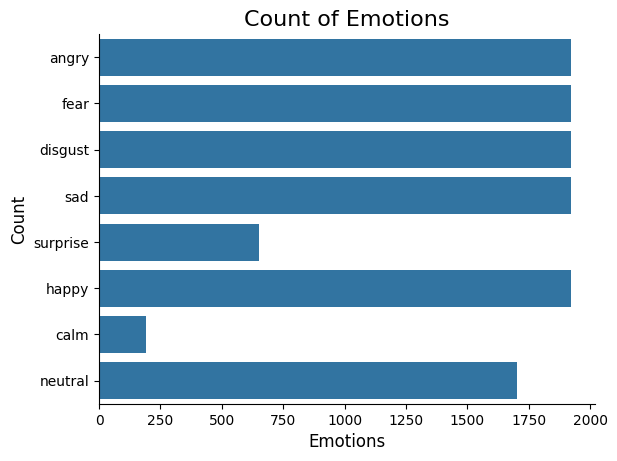

In [10]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [11]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

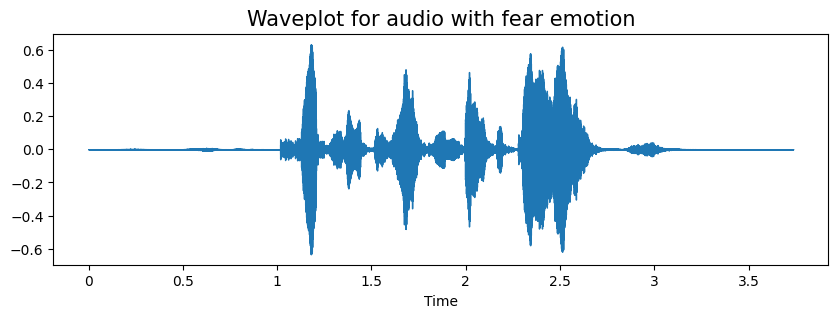

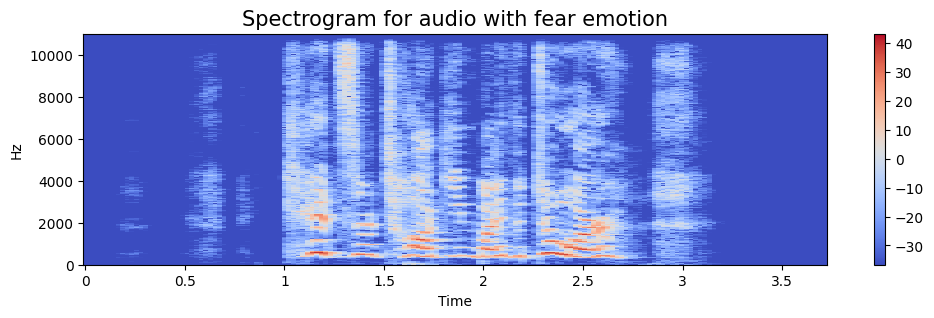

In [12]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

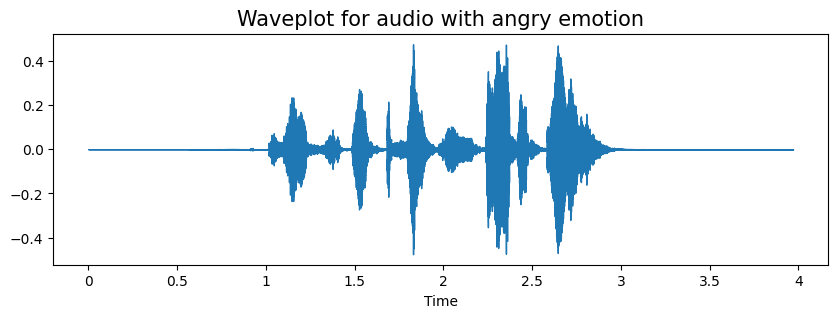

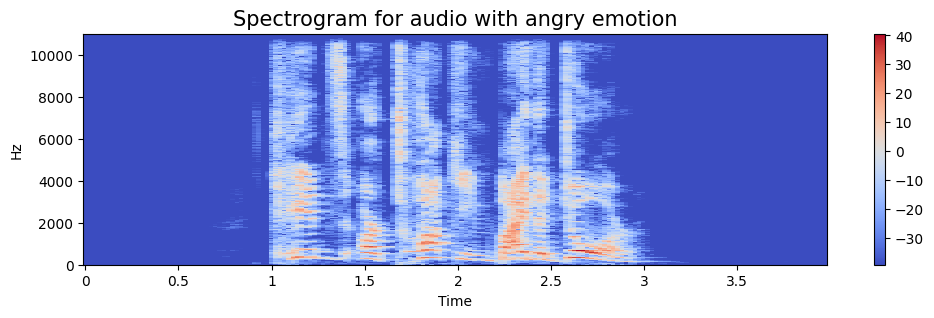

In [13]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

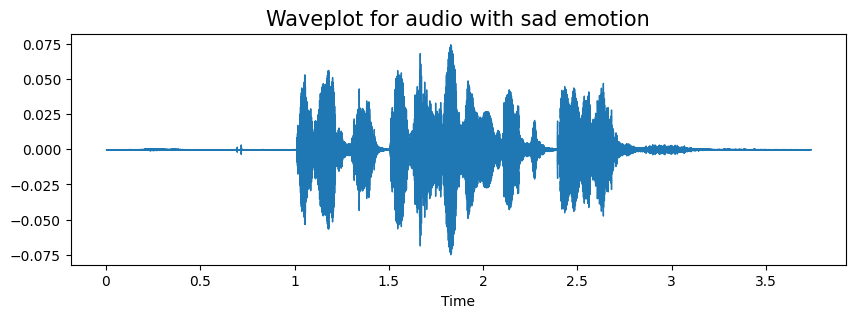

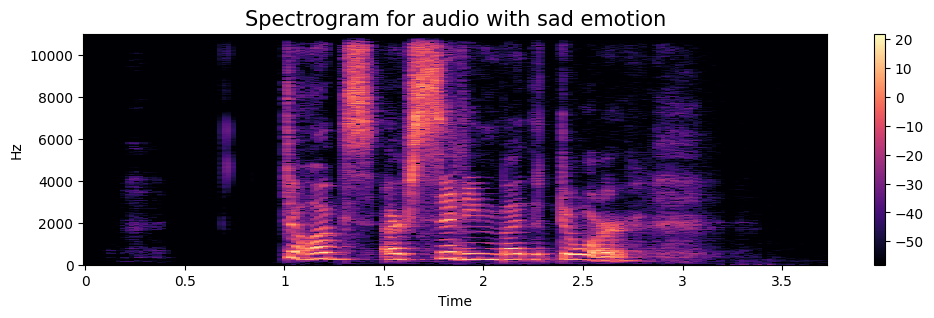

In [14]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

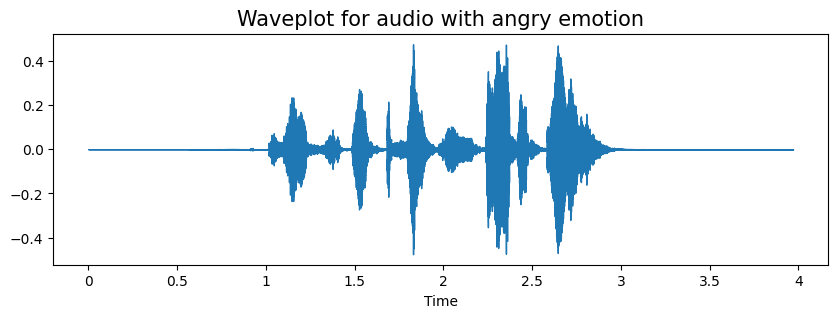

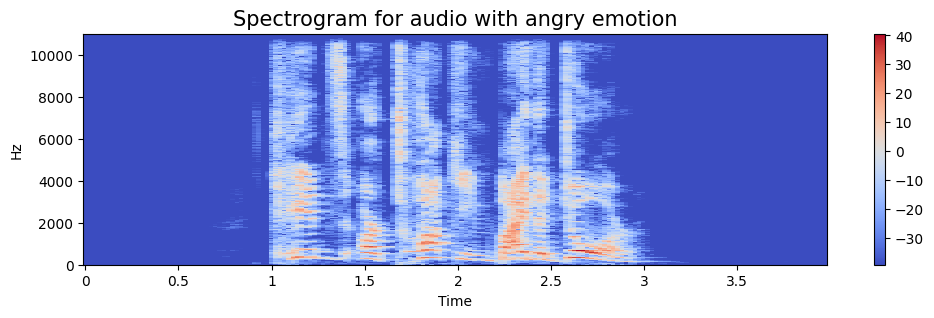

In [15]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [16]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

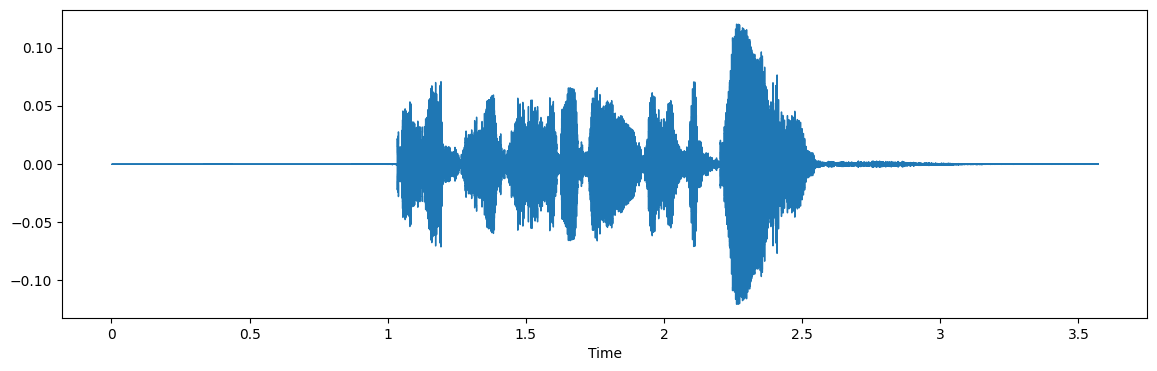

In [17]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

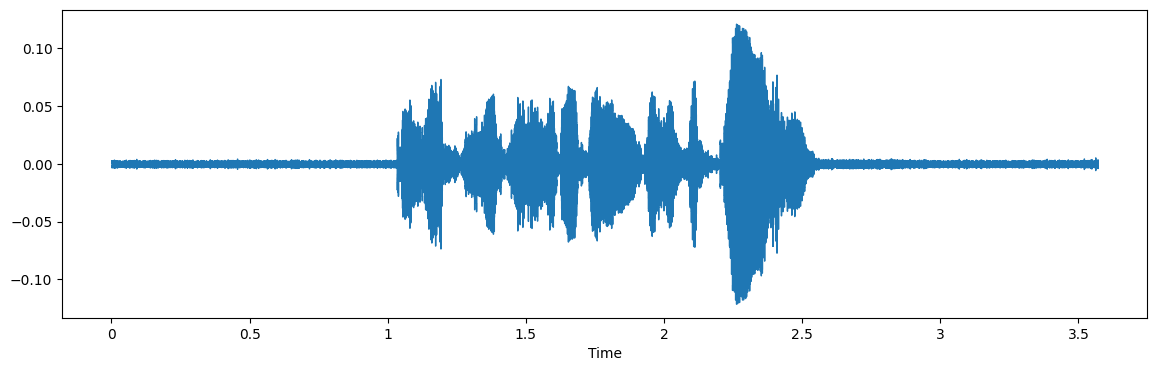

In [18]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

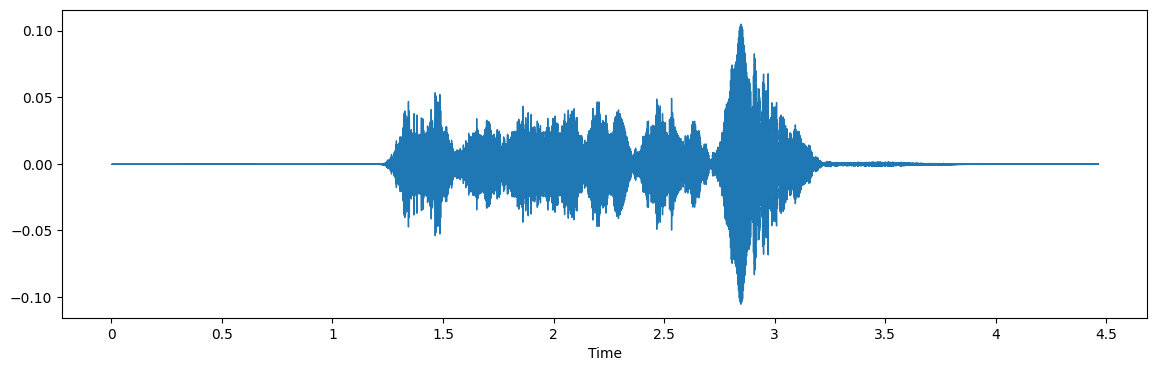

In [19]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

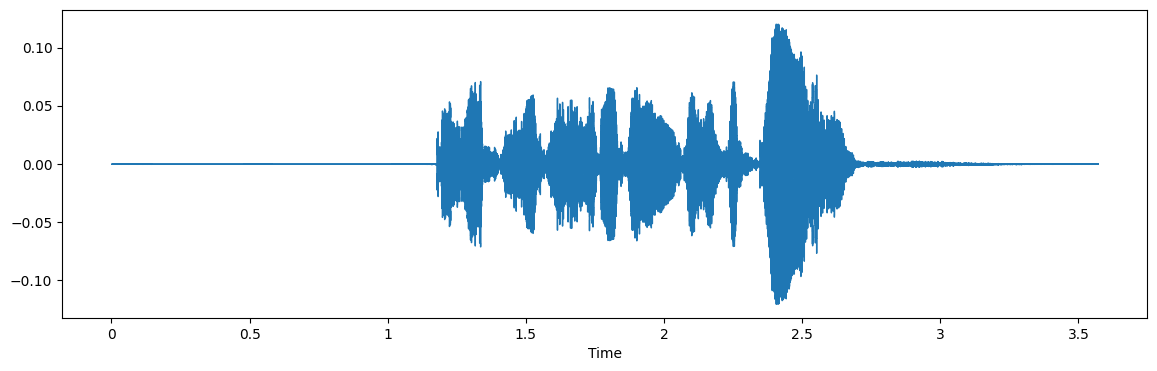

In [20]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

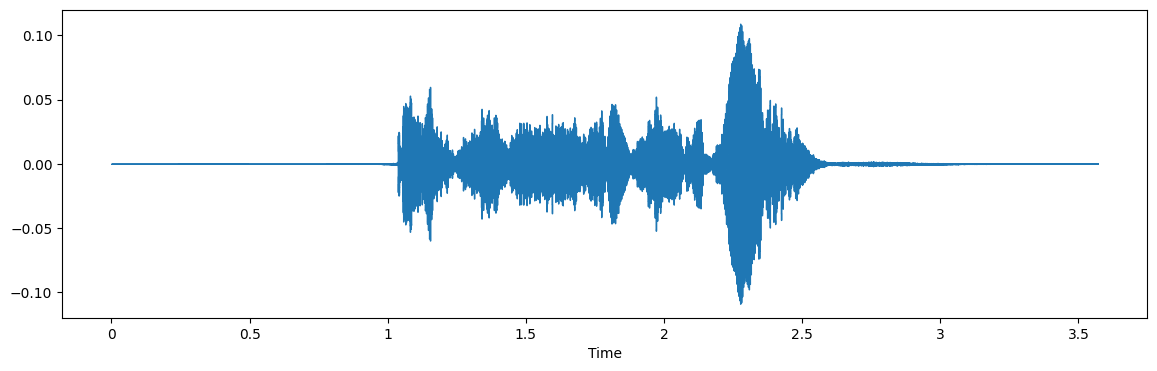

In [21]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [22]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [38]:
import random
X, Y = [], []
# print(data_path.Path[0:10].tolist())
temp = list(zip(data_path.Path.tolist(), data_path.Emotions.tolist()))
random.shuffle(temp)
paths, emotions = zip(*temp)
for path, emotion in zip(paths[0:30000], emotions[0:30000]):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [39]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [40]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.078842  0.500435  0.494812  0.538600  0.512022  0.528554  0.620046   
1  0.267867  0.661586  0.657976  0.708339  0.696007  0.690735  0.676584   
2  0.097057  0.479359  0.466277  0.477302  0.491153  0.465336  0.573747   
3  0.048517  0.576324  0.451708  0.234993  0.251713  0.322669  0.294141   
4  0.116335  0.679802  0.561180  0.370347  0.386760  0.442764  0.383938   

          7         8         9  ...           153           154  \
0  0.649558  0.630448  0.589505  ...  2.175395e-07  1.988612e-07   
1  0.696202  0.674960  0.633894  ...  6.452861e-02  6.622823e-02   
2  0.702794  0.673834  0.634290  ...  1.757314e-07  1.510244e-07   
3  0.356426  0.429781  0.343736  ...  1.220119e-04  2.036403e-04   
4  0.403934  0.485530  0.404887  ...  6.620243e-04  7.483466e-04   

            155           156           157           158           159  \
0  1.856757e-07  1.759185e-07  1.686735e-07  1.634488e-07  1.596578e-07   
1  6.318561e-02  6.299529e-02  6.865667e-02  6.939420e-02  7.017734e-02   
2  1.347040e-07  1.231313e-07  1.147763e-07  1.090107e-07  1.055021e-07   
3  9.755548e-05  2.433240e-05  2.169434e-05  2.431015e-05  6.313271e-05   
4  6.421016e-04  5.784593e-04  5.832094e-04  6.250538e-04  6.293357e-04   

            160           161  labels  
0  1.571822e-07  1.556606e-07   angry  
1  6.910349e-02  6.463046e-02   angry  
2  8.407543e-08  3.331618e-08   angry  
3  8.374009e-05  1.897914e-05   angry  
4  6.089686e-04  5.542039e-04   angry  

[5 rows x 163 columns]

In [41]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [42]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [43]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [44]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [45]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [46]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.2583 - loss: 1.8274 - val_accuracy: 0.4169 - val_loss: 1.4690 - learning_rate: 0.0010
Epoch 2/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.3988 - loss: 1.4878 - val_accuracy: 0.4654 - val_loss: 1.3223 - learning_rate: 0.0010
Epoch 3/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.4405 - loss: 1.3852 - val_accuracy: 0.4857 - val_loss: 1.2901 - learning_rate: 0.0010
Epoch 4/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.4694 - loss: 1.3163 - val_accuracy: 0.4980 - val_loss: 1.2394 - learning_rate: 0.0010
Epoch 5/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.4700 - loss: 1.2953 - val_accuracy: 0.5022 - val_loss: 1.2332 - learning_rate: 0.0010
Epoch 6/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.4939 - loss: 1.2584 - val_accuracy: 0.5221 - val_loss: 1.2004 - learning_rate: 0.0010
Epoch 7/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.5129 - l

286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6055 - loss: 1.0652
Accuracy of our model on test data :  60.88576912879944 %


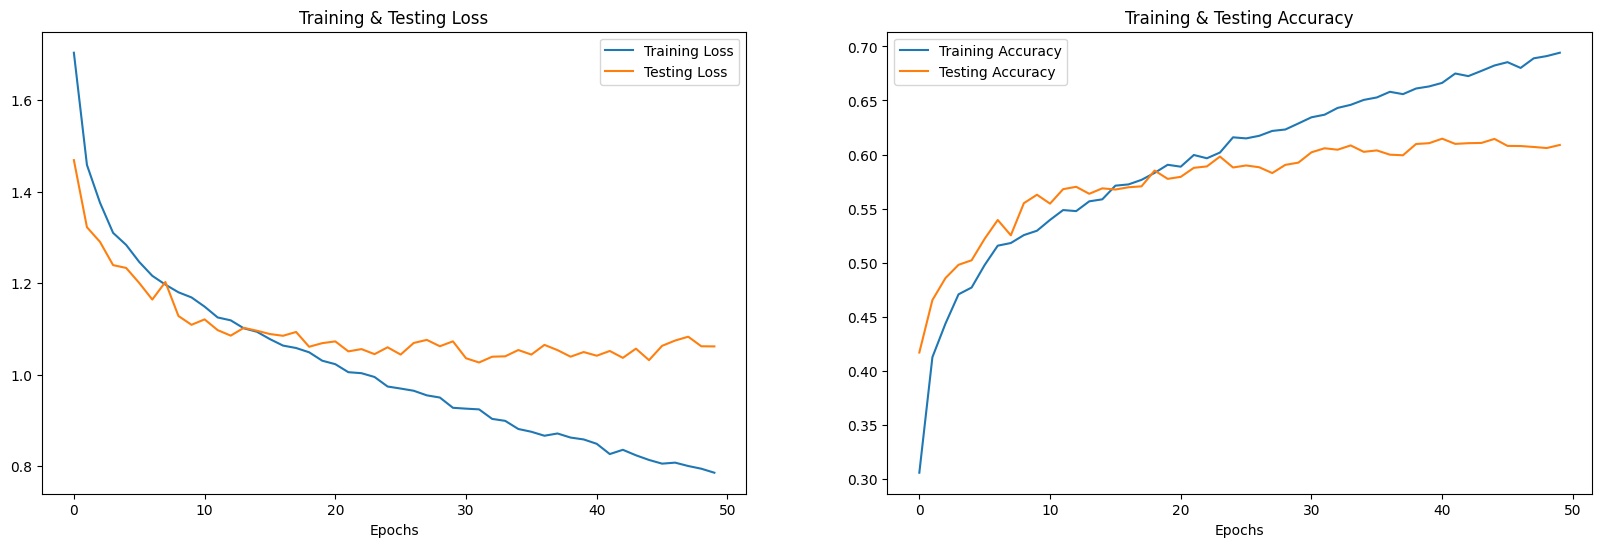

In [48]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [49]:
pred_test = model.predict(x_test)
# y_pred = encoder.inverse_transform(pred_test)

# y_test = encoder.inverse_transform(y_test)

286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [50]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         happy
1          neutral       neutral
2          neutral          calm
3            happy          fear
4            angry         angry
5              sad           sad
6              sad           sad
7          neutral       disgust
8             fear      surprise
9          neutral       neutral

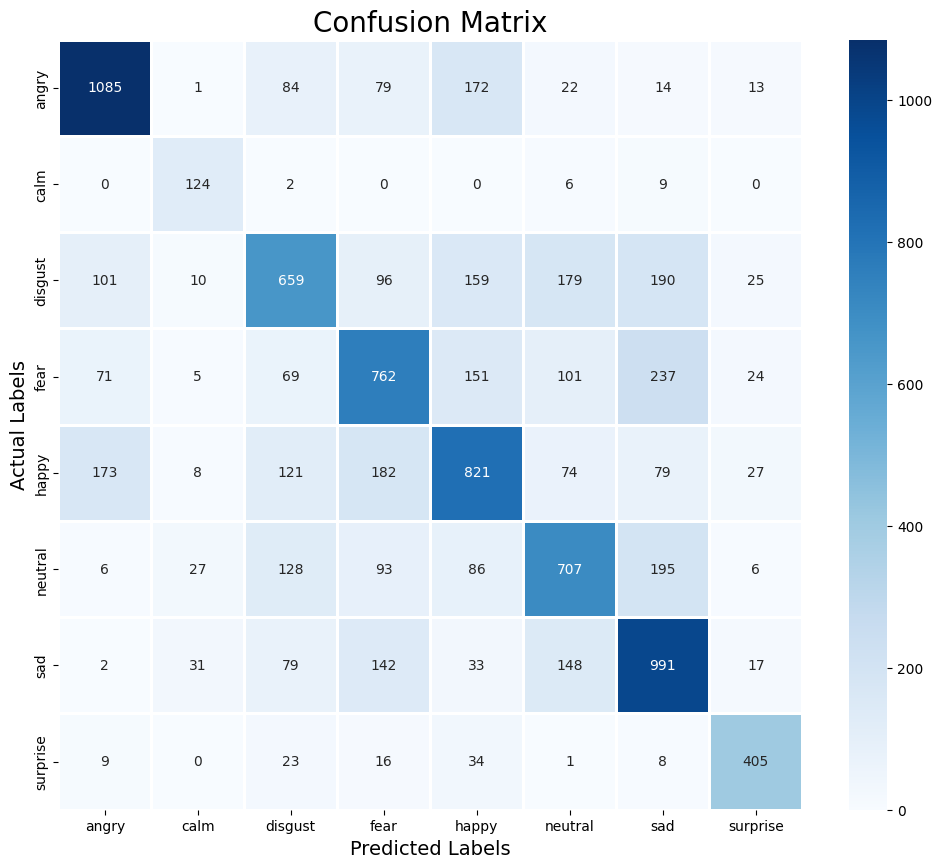

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.74      0.74      1470
        calm       0.60      0.88      0.71       141
     disgust       0.57      0.46      0.51      1419
        fear       0.56      0.54      0.55      1420
       happy       0.56      0.55      0.56      1485
     neutral       0.57      0.57      0.57      1248
         sad       0.58      0.69      0.63      1443
    surprise       0.78      0.82      0.80       496

    accuracy                           0.61      9122
   macro avg       0.62      0.66      0.63      9122
weighted avg       0.61      0.61      0.61      9122



In [72]:
model.save("audio_model_weights.keras")

In [63]:
reconstructed_model = keras.models.load_model("audio_model_weights.keras")
pred_test = reconstructed_model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
# y_test = encoder.inverse_transform(y_test)
print(y_pred)
print(y_test)

286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
[['angry']
 ['neutral']
 ['neutral']
 ...
 ['angry']
 ['neutral']
 ['sad']]
[['happy']
 ['neutral']
 ['calm']
 ...
 ['happy']
 ['neutral']
 ['angry']]


In [70]:
def identify_agressive(audio_path):
    paths = []
    paths.append(get_features(audio_path))
    paths = Features.iloc[: ,:-1].values
    scaler = StandardScaler()
    audio_features = scaler.fit_transform(paths)
    audio_features = np.expand_dims(audio_features, axis=2)
    pred = reconstructed_model.predict(audio_features)
    pred = encoder.inverse_transform(pred)
    if "angry" in pred:
        print("Agressive behavior identified. Please review footage: ", audio_path)
    

In [71]:
identify_agressive("ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav")

1141/1141 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step
Agressive behavior identified. Please review footage:  ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
